### Importing packages and data_utils.py

In [1]:
from climsim_utils.data_utils import *

2024-01-11 14:01:23.520167: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 14:01:42.118362: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Instantiate class

In [2]:
grid_path = '/ocean/projects/atm200007p/jlin96/ClimSim/grid_info/ClimSim_low-res_grid-info.nc'
norm_path = '/ocean/projects/atm200007p/jlin96/ClimSim/preprocessing/normalizations/'

grid_info = xr.open_dataset(grid_path)
input_mean = xr.open_dataset(norm_path + 'inputs/input_mean.nc')
input_max = xr.open_dataset(norm_path + 'inputs/input_max.nc')
input_min = xr.open_dataset(norm_path + 'inputs/input_min.nc')
output_scale = xr.open_dataset(norm_path + 'outputs/output_scale.nc')

data = data_utils(grid_info = grid_info,
                  input_mean = input_mean,
                  input_max = input_max,
                  input_min = input_min,
                  output_scale = output_scale)

# set variables to V1 subset
data.set_to_v1_vars()

### Load scoring data

In [3]:
data.model_names = ['HSR', 'RPN', 'cVAE']

scoring_input_path = "/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_input.npy"
scoring_target_path = "/ocean/projects/atm200007p/jlin96/neurips_proj/e3sm_train_npy/scoring_target.npy"

# path to target input
data.input_scoring = np.load(scoring_input_path)

# path to target output
data.target_scoring = np.load(scoring_target_path)

data.set_pressure_grid(data_split = 'scoring')

data.reweight_target(data_split = 'scoring')

### Load samples

In [4]:
cvae_samples_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/shared_folder/final_metrics/predictions/cVAE/cvae_samples_manual.h5'
hsr_samples_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/crps_ingredients/hsr_samples_bestcrps.h5'
rpn_samples_path = '/ocean/projects/atm200007p/jlin96/neurips_proj/crps_ingredients/RPN_crps_32_samples.npy'

cvae_color = '#D55E00'
hsr_color = '#E69F00'
rpn_color = '#009E73'

In [5]:
cvae_samples = data_utils.load_h5_file(cvae_samples_path)

In [6]:
cvae_samples.shape

(1681920, 128, 128)

In [7]:
cvae_samples = cvae_samples[:,:,:32]

In [9]:
cvae_samples = np.expand_dims(data.output_weighting(cvae_samples[:,:,0], data_split = 'scoring', just_weights = True), axis = -1) * cvae_samples

In [8]:
hsr_samples = data_utils.load_h5_file(hsr_samples_path)
hsr_samples = np.expand_dims(data.output_weighting(hsr_samples[:,:,0], data_split = 'scoring', just_weights = True), axis = -1) * hsr_samples

rpn_samples = data_utils.load_npy_file(rpn_samples_path)
rpn_samples = np.expand_dims(data.output_weighting(rpn_samples[:,:,0], data_split = 'scoring', just_weights = True), axis = -1) * rpn_samples

### Define useful functions

In [10]:
num_samples = 1681920

def reshape_output(output, var):
    if var == 'ptend_t':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon, 60))
    elif var == 'ptend_q0001':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon, 60))
    elif var == 'netsw':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'flwds':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'precsc':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'precc':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'sols':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'soll':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'solsd':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    elif var == 'solld':
        ans = output.reshape((int(num_samples/data.num_latlon), data.num_latlon))
    return ans

def reshape_samplepreds(samplepreds, var, num_crps):
    if var == 'ptend_t':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,:60,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'ptend_q0001':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,60:120,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'netsw':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,120,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'flwds':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,121,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'precsc':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,122,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'precc':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,123,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'sols':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,124,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'soll':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,125,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'solsd':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,126,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    elif var == 'solld':
        ans = np.concatenate([np.expand_dims(reshape_output(samplepreds[:,127,crps_idx], var), -1) for crps_idx in range(num_crps)], axis = -1)
    return ans

### Calculate CRPS

In [11]:
hsr_ptend_t_samples = reshape_samplepreds(hsr_samples, 'ptend_t', 32)
hsr_ptend_q0001_samples = reshape_samplepreds(hsr_samples, 'ptend_q0001', 32)
hsr_netsw_samples = reshape_samplepreds(hsr_samples, 'netsw', 32)
hsr_flwds_samples = reshape_samplepreds(hsr_samples, 'flwds', 32)
hsr_precsc_samples = reshape_samplepreds(hsr_samples, 'precsc', 32)
hsr_precc_samples = reshape_samplepreds(hsr_samples, 'precc', 32)
hsr_sols_samples = reshape_samplepreds(hsr_samples, 'sols', 32)
hsr_soll_samples = reshape_samplepreds(hsr_samples, 'soll', 32)
hsr_solsd_samples = reshape_samplepreds(hsr_samples, 'solsd', 32)
hsr_solld_samples = reshape_samplepreds(hsr_samples, 'solld', 32)

hsr_ptend_t_CRPS = data.calc_CRPS(hsr_ptend_t_samples, data.target_weighted_scoring['ptend_t'])
hsr_ptend_q0001_CRPS = data.calc_CRPS(hsr_ptend_q0001_samples, data.target_weighted_scoring['ptend_q0001'])
hsr_netsw_CRPS = data.calc_CRPS(hsr_netsw_samples, data.target_weighted_scoring['cam_out_NETSW'])
hsr_flwds_CRPS = data.calc_CRPS(hsr_flwds_samples, data.target_weighted_scoring['cam_out_FLWDS'])
hsr_precsc_CRPS = data.calc_CRPS(hsr_precsc_samples, data.target_weighted_scoring['cam_out_PRECSC'])
hsr_precc_CRPS = data.calc_CRPS(hsr_precc_samples, data.target_weighted_scoring['cam_out_PRECC'])
hsr_sols_CRPS = data.calc_CRPS(hsr_sols_samples, data.target_weighted_scoring['cam_out_SOLS'])
hsr_soll_CRPS = data.calc_CRPS(hsr_soll_samples, data.target_weighted_scoring['cam_out_SOLL'])
hsr_solsd_CRPS = data.calc_CRPS(hsr_solsd_samples, data.target_weighted_scoring['cam_out_SOLSD'])
hsr_solld_CRPS = data.calc_CRPS(hsr_solld_samples, data.target_weighted_scoring['cam_out_SOLLD'])

In [12]:
rpn_ptend_t_samples = reshape_samplepreds(rpn_samples, 'ptend_t', 32)
rpn_ptend_q0001_samples = reshape_samplepreds(rpn_samples, 'ptend_q0001', 32)
rpn_netsw_samples = reshape_samplepreds(rpn_samples, 'netsw', 32)
rpn_flwds_samples = reshape_samplepreds(rpn_samples, 'flwds', 32)
rpn_precsc_samples = reshape_samplepreds(rpn_samples, 'precsc', 32)
rpn_precc_samples = reshape_samplepreds(rpn_samples, 'precc', 32)
rpn_sols_samples = reshape_samplepreds(rpn_samples, 'sols', 32)
rpn_soll_samples = reshape_samplepreds(rpn_samples, 'soll', 32)
rpn_solsd_samples = reshape_samplepreds(rpn_samples, 'solsd', 32)
rpn_solld_samples = reshape_samplepreds(rpn_samples, 'solld', 32)

rpn_ptend_t_CRPS = data.calc_CRPS(rpn_ptend_t_samples, data.target_weighted_scoring['ptend_t'])
rpn_ptend_q0001_CRPS = data.calc_CRPS(rpn_ptend_q0001_samples, data.target_weighted_scoring['ptend_q0001'])
rpn_netsw_CRPS = data.calc_CRPS(rpn_netsw_samples, data.target_weighted_scoring['cam_out_NETSW'])
rpn_flwds_CRPS = data.calc_CRPS(rpn_flwds_samples, data.target_weighted_scoring['cam_out_FLWDS'])
rpn_precsc_CRPS = data.calc_CRPS(rpn_precsc_samples, data.target_weighted_scoring['cam_out_PRECSC'])
rpn_precc_CRPS = data.calc_CRPS(rpn_precc_samples, data.target_weighted_scoring['cam_out_PRECC'])
rpn_sols_CRPS = data.calc_CRPS(rpn_sols_samples, data.target_weighted_scoring['cam_out_SOLS'])
rpn_soll_CRPS = data.calc_CRPS(rpn_soll_samples, data.target_weighted_scoring['cam_out_SOLL'])
rpn_solsd_CRPS = data.calc_CRPS(rpn_solsd_samples, data.target_weighted_scoring['cam_out_SOLSD'])
rpn_solld_CRPS = data.calc_CRPS(rpn_solld_samples, data.target_weighted_scoring['cam_out_SOLLD'])

In [13]:
cvae_ptend_t_samples = reshape_samplepreds(cvae_samples, 'ptend_t', 32)
cvae_ptend_q0001_samples = reshape_samplepreds(cvae_samples, 'ptend_q0001', 32)
cvae_netsw_samples = reshape_samplepreds(cvae_samples, 'netsw', 32)
cvae_flwds_samples = reshape_samplepreds(cvae_samples, 'flwds', 32)
cvae_precsc_samples = reshape_samplepreds(cvae_samples, 'precsc', 32)
cvae_precc_samples = reshape_samplepreds(cvae_samples, 'precc', 32)
cvae_sols_samples = reshape_samplepreds(cvae_samples, 'sols', 32)
cvae_soll_samples = reshape_samplepreds(cvae_samples, 'soll', 32)
cvae_solsd_samples = reshape_samplepreds(cvae_samples, 'solsd', 32)
cvae_solld_samples = reshape_samplepreds(cvae_samples, 'solld', 32)

cvae_ptend_t_CRPS = data.calc_CRPS(cvae_ptend_t_samples, data.target_weighted_scoring['ptend_t'])
cvae_ptend_q0001_CRPS = data.calc_CRPS(cvae_ptend_q0001_samples, data.target_weighted_scoring['ptend_q0001'])
cvae_netsw_CRPS = data.calc_CRPS(cvae_netsw_samples, data.target_weighted_scoring['cam_out_NETSW'])
cvae_flwds_CRPS = data.calc_CRPS(cvae_flwds_samples, data.target_weighted_scoring['cam_out_FLWDS'])
cvae_precsc_CRPS = data.calc_CRPS(cvae_precsc_samples, data.target_weighted_scoring['cam_out_PRECSC'])
cvae_precc_CRPS = data.calc_CRPS(cvae_precc_samples, data.target_weighted_scoring['cam_out_PRECC'])
cvae_sols_CRPS = data.calc_CRPS(cvae_sols_samples, data.target_weighted_scoring['cam_out_SOLS'])
cvae_soll_CRPS = data.calc_CRPS(cvae_soll_samples, data.target_weighted_scoring['cam_out_SOLL'])
cvae_solsd_CRPS = data.calc_CRPS(cvae_solsd_samples, data.target_weighted_scoring['cam_out_SOLSD'])
cvae_solld_CRPS = data.calc_CRPS(cvae_solld_samples, data.target_weighted_scoring['cam_out_SOLLD'])

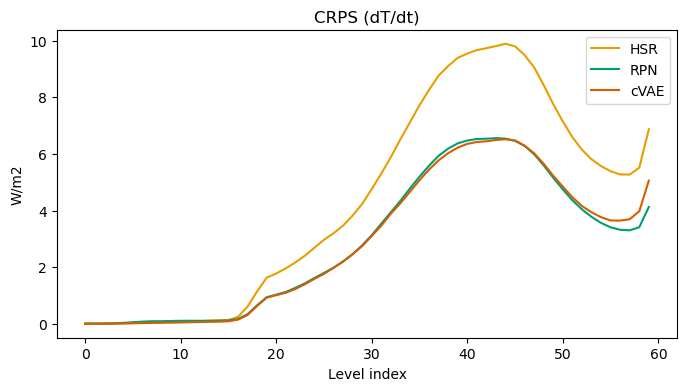

In [19]:
plt.figure(figsize=(8, 4)) 
plt.plot(range(60), hsr_ptend_t_CRPS, label='HSR', color = hsr_color)
plt.plot(range(60), rpn_ptend_t_CRPS, label='RPN', color = rpn_color)
plt.plot(range(60), cvae_ptend_t_CRPS, label='cVAE', color = cvae_color)
plt.xlabel('Level index')
plt.ylabel('W/m2')
plt.title('CRPS (dT/dt)')
plt.legend()

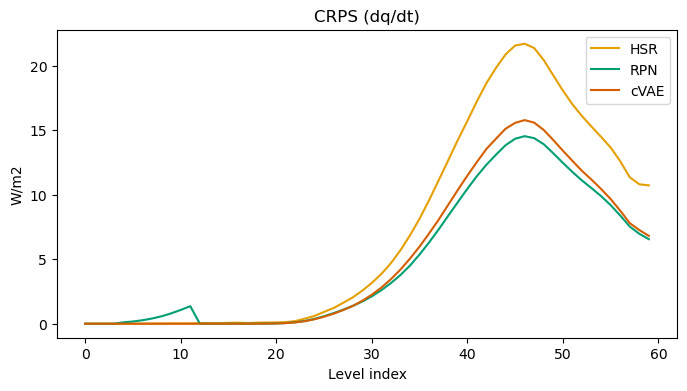

In [20]:
plt.figure(figsize=(8, 4)) 
plt.plot(range(60), hsr_ptend_q0001_CRPS, label = 'HSR', color = hsr_color)
plt.plot(range(60), rpn_ptend_q0001_CRPS, label = 'RPN', color = rpn_color)
plt.plot(range(60), cvae_ptend_q0001_CRPS, label = 'cVAE', color = cvae_color)
plt.xlabel('Level index')
plt.ylabel('W/m2')
plt.title('CRPS (dq/dt)')
plt.legend()

In [21]:
print("CRPS for HSR")
print('ptend_t')
print(np.mean(hsr_ptend_t_CRPS))
print('ptend_q0001')
print(np.mean(hsr_ptend_q0001_CRPS))
print('netsw')
print(hsr_netsw_CRPS)
print('flwds')
print(hsr_flwds_CRPS)
print('precsc')
print(hsr_precsc_CRPS)
print('precc')
print(hsr_precc_CRPS)
print('sols')
print(hsr_sols_CRPS)
print('soll')
print(hsr_soll_CRPS)
print('solsd')
print(hsr_solsd_CRPS)
print('solld')
print(hsr_solld_CRPS)

CRPS for HSR
ptend_t
4.313504539871828
ptend_q0001
7.12245889893346
netsw
26.895344194394585
flwds
9.065343572310345
precsc
6.618401567459723
precc
68.50627526150829
sols
15.12969800863887
soll
18.457977895795874
solsd
9.058934716176298
solld
8.581095657206207


In [22]:
print("CRPS for RPN")
print('ptend_t')
print(np.mean(rpn_ptend_t_CRPS))
print('ptend_q0001')
print(np.mean(rpn_ptend_q0001_CRPS))
print('netsw')
print(rpn_netsw_CRPS)
print('flwds')
print(rpn_flwds_CRPS)
print('precsc')
print(rpn_precsc_CRPS)
print('precc')
print(rpn_precc_CRPS)
print('sols')
print(rpn_sols_CRPS)
print('soll')
print(rpn_soll_CRPS)
print('solsd')
print(rpn_solsd_CRPS)
print('solld')
print(rpn_solld_CRPS)

CRPS for RPN
ptend_t
2.8339022416018427
ptend_q0001
4.836236775278909
netsw
25.52540066464738
flwds
8.089928346967545
precsc
4.2208184862440286
precc
42.654252680984726
sols
13.49815523576003
soll
16.114603384709252
solsd
7.165124211075875
solld
6.630592244535045


In [23]:
print("CRPS for cVAE")
print('ptend_t')
print(np.mean(cvae_ptend_t_CRPS))
print('ptend_q0001')
print(np.mean(cvae_ptend_q0001_CRPS))
print('netsw')
print(cvae_netsw_CRPS)
print('flwds')
print(cvae_flwds_CRPS)
print('precsc')
print(cvae_precsc_CRPS)
print('precc')
print(cvae_precc_CRPS)
print('sols')
print(cvae_sols_CRPS)
print('soll')
print(cvae_soll_CRPS)
print('solsd')
print(cvae_solsd_CRPS)
print('solld')
print(cvae_solld_CRPS)

CRPS for cVAE
ptend_t
2.8504252865757516
ptend_q0001
5.130390935874431
netsw
23.056108295577115
flwds
7.251907936160639
precsc
4.371026159008593
precc
42.6236004156111
sols
13.70586179628509
soll
16.30985747819903
solsd
6.333200907220096
solld
6.427539581252627


In [26]:
# Define the categories and number of model groups
categories = ['dT/dt', 'dq/dt', 'NETSW', 'FLWDS', 'PRECSC', 'PRECC', 'SOLS', 'SOLL', 'SOLSD', 'SOLLD']
num_groups = 3
colors = [hsr_color, rpn_color, cvae_color]
values = np.zeros((num_groups, len(categories)))

values[0,0] = np.mean(hsr_ptend_t_CRPS)
values[1,0] = np.mean(rpn_ptend_t_CRPS)
values[2,0] = np.mean(cvae_ptend_t_CRPS)

values[0,1] = np.mean(hsr_ptend_q0001_CRPS)
values[1,1] = np.mean(rpn_ptend_q0001_CRPS)
values[2,1] = np.mean(cvae_ptend_q0001_CRPS)

values[0,2] = hsr_netsw_CRPS
values[1,2] = rpn_netsw_CRPS
values[2,2] = cvae_netsw_CRPS

values[0,3] = hsr_flwds_CRPS
values[1,3] = rpn_flwds_CRPS
values[2,3] = cvae_flwds_CRPS

values[0,4] = hsr_precsc_CRPS
values[1,4] = rpn_precsc_CRPS
values[2,4] = cvae_precsc_CRPS

values[0,5] = hsr_precc_CRPS
values[1,5] = rpn_precc_CRPS
values[2,5] = cvae_precc_CRPS

values[0,6] = hsr_sols_CRPS
values[1,6] = rpn_sols_CRPS
values[2,6] = cvae_sols_CRPS

values[0,7] = hsr_soll_CRPS
values[1,7] = rpn_soll_CRPS
values[2,7] = cvae_soll_CRPS

values[0,8] = hsr_solsd_CRPS
values[1,8] = rpn_solsd_CRPS
values[2,8] = cvae_solsd_CRPS

values[0,9] = hsr_solld_CRPS
values[1,9] = rpn_solld_CRPS
values[2,9] = cvae_solld_CRPS

In [ ]:
# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10, 3))

# Plot the bars for each model group
for i in range(num_groups):
    ax.bar(pos + i * width, values[i], width, label=f'Model {i+1}', color=colors[i])

# Set the y-axis to log scale
# ax.set_yscale('log')

# Set the axis labels and title
ax.set_ylabel('W/m2')

# Set the x-axis category labels
ax.set_xticks(pos + width * (num_groups - 1) / 2)
ax.set_xticklabels(categories)

# Add a legend
# ax.legend()

# Rotate the tick labels for better readability
# plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.setp(ax.get_xticklabels())

# Save the recreated plot to a file
recreated_plot_path = './crps_bar_plot_corrected.png'
# plt.savefig(recreated_plot_path)
plt.show(), recreated_plot_path